In [1]:
from skimage import io
from matplotlib import pyplot as plt

In [2]:
sample1 = io.imread('images/sample1.jpg', as_gray=True)
sample2 = io.imread('images/sample2.jpg', as_gray=True)
sample3 = io.imread('images/sample3.jpg', as_gray=True)
sample4 = io.imread('images/sample4.jpg', as_gray=True)
sample5 = io.imread('images/sample5.jpg', as_gray=True)

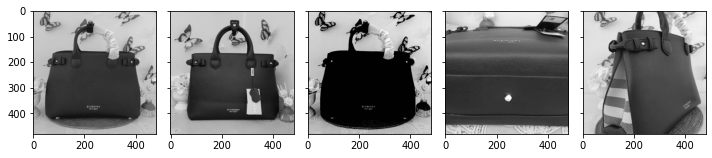

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(sample1, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[1].imshow(sample2, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[2].imshow(sample3, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[3].imshow(sample4, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[4].imshow(sample5, cmap=plt.cm.gray, vmin=0, vmax=1)

plt.tight_layout()
plt.show()

# MSE

In [4]:
import numpy as np

def mse(x: np.ndarray, y: np.ndarray):
    return np.linalg.norm(x - y)

for index, el in enumerate([sample1, sample2, sample3, sample4, sample5]):
    if mse(sample1, el) == 0.0:
        print('sample{} is equal to sample1'.format(index + 1))

sample1 is equal to sample1


# SSIM

In [5]:
from skimage.metrics import structural_similarity as ssim

for index, el in enumerate([sample1, sample2, sample3, sample4, sample5]):
    if ssim(sample1, el) == 1.0:
        print('sample{} is equal to sample1'.format(index + 1))

sample1 is equal to sample1


# Histogram

In [6]:
from skimage import exposure

hist1, _ = exposure.histogram(sample1)
hist2, _ = exposure.histogram(sample2)
hist3, _ = exposure.histogram(sample3)
hist4, _ = exposure.histogram(sample4)
hist5, _ = exposure.histogram(sample5)

for index, el in enumerate([hist1, hist2, hist3, hist4, hist5]):
    if mse(hist1, el) == 0.0:
        print('sample{} is equal to sample1'.format(index + 1))

sample1 is equal to sample1


# imagehash

In [7]:
import cv2
import scipy.fftpack

def get_image_ahash(img: np.ndarray, hash_size: int=8) -> int:
    resized = cv2.resize(img, (hash_size, hash_size))

    mean = resized.mean()
    diff = resized > mean

    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

def get_image_phash(img: np.ndarray, hash_size: int=8, freq_factor: int=4) -> int:
    img_size = hash_size * freq_factor
    resized = cv2.resize(img, (img_size, img_size))

    dct = scipy.fftpack.dct(scipy.fftpack.dct(resized, axis=0), axis=1)
    dctlowfreq = dct[:hash_size, :hash_size]
    med = np.median(dctlowfreq)
    diff = dctlowfreq > med

    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

def get_image_dhash(img: np.ndarray, hash_size: int=8) -> int:
    resized = cv2.resize(img, (hash_size + 1, hash_size))

    diff = resized[:, 1:] > resized[:, :-1]

    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

In [8]:
sample1_hash = [get_image_ahash(sample1), get_image_phash(sample1), get_image_dhash(sample1)]
sample2_hash = [get_image_ahash(sample2), get_image_phash(sample2), get_image_dhash(sample2)]
sample3_hash = [get_image_ahash(sample3), get_image_phash(sample3), get_image_dhash(sample3)]
sample4_hash = [get_image_ahash(sample4), get_image_phash(sample4), get_image_dhash(sample4)]
sample5_hash = [get_image_ahash(sample5), get_image_phash(sample5), get_image_dhash(sample5)]

In [9]:
for index, el in enumerate([sample1_hash, sample2_hash, sample3_hash, sample4_hash, sample5_hash]):
    if np.all(el == sample1_hash):
        print('sample{} is equal to sample1'.format(index + 1))

sample1 is equal to sample1


# dhash + LSH

In [10]:
from typing import Dict, List, Optional, Tuple

def get_dhash_signature(img: np.ndarray, hash_size: int=16) -> np.ndarray:
    resized = cv2.resize(img, (hash_size + 1, hash_size))

    diff = resized[:, 1:] > resized[:, :-1]

    return 1 * diff.flatten()

hash_size = 16
bands = 16
threshold = 0.9
rows: int = int(hash_size**2/bands)
signatures = dict()
hash_buckets_list: List[Dict[str, List[str]]] = [dict() for _ in range(bands)]

for fh, sample in enumerate([sample1, sample2, sample3, sample4, sample5, sample1]):
    signature = get_dhash_signature(sample)
    
    signatures[fh] = np.packbits(signature)
        
    for i in range(bands):
        signature_band = signature[i*rows:(i+1)*rows]
        signature_band_bytes = signature_band.tostring()
        if signature_band_bytes not in hash_buckets_list[i]:
            hash_buckets_list[i][signature_band_bytes] = list()
        hash_buckets_list[i][signature_band_bytes].append(fh)

candidate_pairs = set()
for hash_buckets in hash_buckets_list:
    for hash_bucket in hash_buckets.values():
        if len(hash_bucket) > 1:
            hash_bucket = sorted(hash_bucket)
            for i in range(len(hash_bucket)):
                for j in range(i+1, len(hash_bucket)):
                    candidate_pairs.add(
                        tuple([hash_bucket[i],hash_bucket[j]])
                    )

near_duplicates = list()
for cpa, cpb in candidate_pairs:
    hd = sum(np.bitwise_xor(
            np.unpackbits(signatures[cpa]), 
            np.unpackbits(signatures[cpb])
    ))
    similarity = (hash_size**2 - hd) / hash_size**2
    if similarity > threshold:
        near_duplicates.append((cpa, cpb, similarity))

near_duplicates.sort(key=lambda x:x[2], reverse=True)
near_duplicates

[(0, 5, 1.0)]